# Analysis of Corporate Lobbying

<p>
This notebook will contain analysis of the master_df scraped and updated <br>
from corporate_lobbying.ipynb and update_master.ipynb.
<br><br>
This will be a slow burn - my data goes back to Aug 5 2025 and the website which I am <br>
scraping from gets updated daily.
<br><br>
I want to gather data slowly and over time see how the amount of corporate lobbying affects <br>
the stock price of the companies conducting the lobbying.
</p>

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv(r'C:\Users\ronan\Projects\master_df.csv', parse_dates=['Date'], dayfirst=True)

In [17]:
df.shape

(247, 4)

Ticker
NDAQ     650000
RIVN     280000
BWXT     150000
AAL      120000
ML       120000
AAPL     110000
FOX      105000
CMCSA    100000
DVA      100000
UNH       90000
Name: Amount, dtype: int64


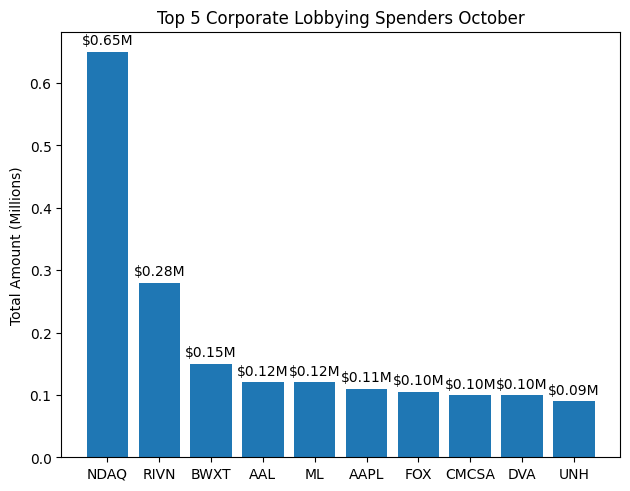

In [ ]:
df_month = df[df['Date'] >= '2025-10-01' ] #get data for the month

totals_monthly = df_month.groupby('Ticker')['Amount'].sum().sort_values(ascending=False).head(10) #group by amount per ticker
print(totals_monthly)

# bar plot
fig, ax = plt.subplots()
bars = ax.bar(totals_monthly.index, totals_monthly.values / 1_000_000)
ax.set_ylabel("Total Amount (Millions)")

ax.bar_label(bars,
             labels=[f"${v/1_000_000:.2f}M" for v in totals_monthly.values],
             padding=3)
plt.tight_layout()
plt.title('Top 5 Corporate Lobbying Spenders October')
plt.show()


Ticker
NDAQ    650000
BWXT    150000
FOX     105000
AAL      90000
BLK      90000
ADI      80000
CRML     70000
SO       60000
CRC      60000
NEE      60000
Name: Amount, dtype: int64


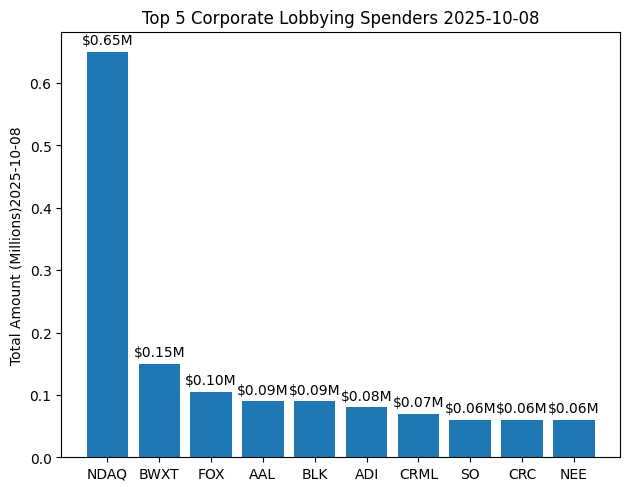

In [ ]:
df_daily = df[df['Date'] == str(pd.to_datetime(dt.date.today()) - dt.timedelta(days=1))[0:10]]

totals_daily = df_daily.groupby('Ticker')['Amount'].sum().sort_values(ascending=False).head(10) #group by amount per ticker
print(totals_daily)

# bar plot
fig, ax = plt.subplots()
bars = ax.bar(totals_daily.index, totals_daily.values / 1_000_000)
ax.set_ylabel(f"Total Amount (Millions)")

ax.bar_label(bars,
             labels=[f"${v/1_000_000:.2f}M" for v in totals_daily.values],
             padding=3)
plt.tight_layout()
plt.title(f'Top 5 Corporate Lobbying Spenders {dt.date.today()}')
plt.show()

In [8]:
df.groupby('Ticker')['Amount'].sum().sort_values(ascending=False).head(10)

Ticker
V       15960000
INTC     4850000
LMT      3921415
PFE      3740000
SO       2780000
TAK      1570000
ARDX     1280000
CTVA      900000
FLR       875887
BAH       680000
Name: Amount, dtype: int64

<p>
Recently the ticker V (Visa) jumped head of INTC as the company who has lobbied the most since I started recording data <br>
I want to look more into this because they spent almost $16m on lobbying
</p>

In [9]:
df[df['Ticker'] == 'V']

,Ticker,Company Name,Amount,Date
88,V,Visa Inc.,1420000,2025-09-26
89,V,Visa Inc.,2030000,2025-09-26
90,V,Visa Inc.,1810000,2025-09-26
91,V,Visa Inc.,1800000,2025-09-26
92,V,Visa Inc.,2110000,2025-09-26
93,V,Visa Inc.,2310000,2025-09-26
94,V,Visa Inc.,2440000,2025-09-26
95,V,Visa Inc.,2040000,2025-09-26


<p>
Holy shit - they spent $16m dollars in one day on lobbying - lets see how their stock has since reacted to see if there has been a<br>
significant reaction
</p>

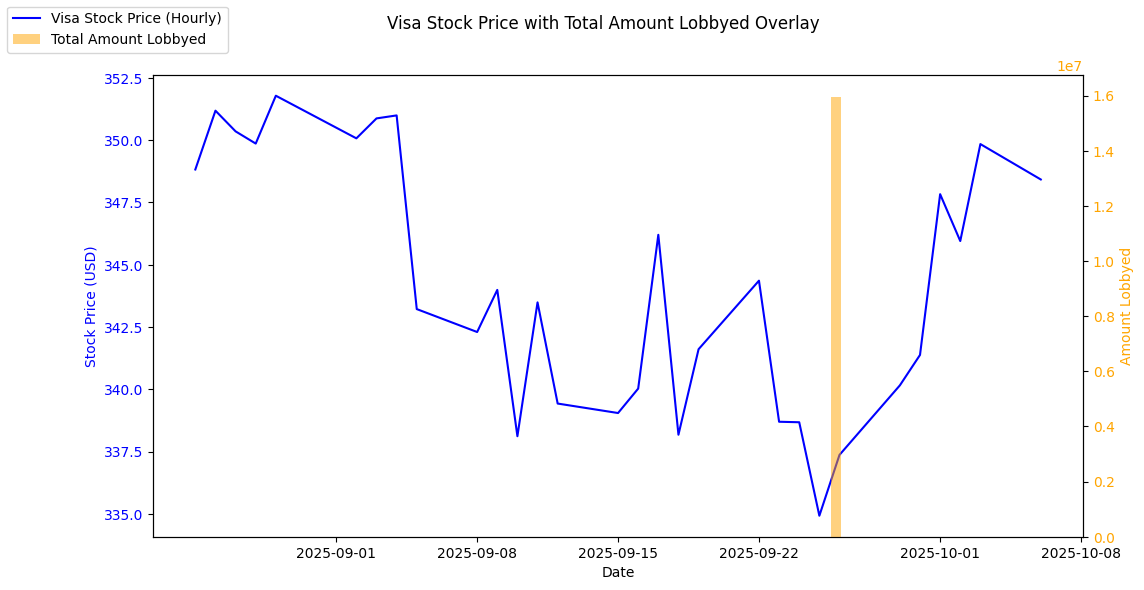

In [12]:
# Example stock data
ticker = yf.Ticker("V")
price_data = ticker.history(period="30d", interval="1d")

# --- Convert Date column to datetime ---
df['Date'] = pd.to_datetime(df['Date'])

# Filter Visa
visa_df = df[df['Ticker'] == 'V']

# Compute total Amount
total_amount = visa_df['Amount'].sum()

# Pick a date to position the bar (e.g., the last date in your stock data)
bar_date = pd.to_datetime("2025-09-26")

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(12,6))

# Stock price
ax1.plot(price_data.index, price_data["Close"], label="Visa Stock Price (Hourly)", color="blue")
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price (USD)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Amount bar on secondary y-axis
ax2 = ax1.twinx()
ax2.bar(bar_date, total_amount, width=0.5, color="orange", alpha=0.5, label="Total Amount Lobbyed")
ax2.set_ylabel("Amount Lobbyed", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

# Title and legends
fig.suptitle("Visa Stock Price with Total Amount Lobbyed Overlay")
fig.legend(loc="upper left")

plt.show()

<p>
So I have my dataset - I want to write a function where you can plot the ticker price against the total amount lobbyed<br>
(like the plot above). But I want it to be automated where the user just inputs the ticker, the start date will be fixed to the<br>
start of the dataset and the end date will be always yesterdays date.
<p>

In [14]:
def get_price_data(ticker, start_date):
    # Always set end date to yesterday
    end_date = dt.date.today() - dt.timedelta(days=1)

    # Download price data
    df = yf.download(
        ticker,
        start=start_date,
        end=end_date,
        progress=False
    )

    # Optional: reset index so Date is a column
    df.reset_index(inplace=True)

    return df

,Ticker,Company Name,Amount,Date
206,SATS,Echostar Corporation/Dba Dish,17500,2025-08-05
207,JNJ,Johnson & Johnson,30000,2025-08-05
208,BSX,Boston Scientific Corporation,20000,2025-08-05
209,LUV,Southwest Airlines,20000,2025-08-05
210,ATEX,Anterix,5000,2025-08-05


In [22]:
df[df['Ticker'] == 'JNJ']

,Ticker,Company Name,Amount,Date
45,JNJ,Johnson & Johnson,30000,2025-10-02
207,JNJ,Johnson & Johnson,30000,2025-08-05


In [7]:
#function to group and sum lobbied amounts by date

def sum_amounts_by_date(df, ticker):
    # Filter for the specific ticker
    ticker_df = df[df['Ticker'] == ticker].copy()

    # Make sure Date is in datetime format
    ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])

    # Group by Date and sum the Amount column
    grouped = (
        ticker_df.groupby('Date', as_index=False)['Amount']
        .sum()
        .sort_values('Date')
    )

    return grouped

In [14]:
sum_amounts_by_date(df=df, ticker='RIVN')

,Date,Amount
0,2025-10-02,220000
1,2025-10-03,60000


In [ ]:
def stock_lobby_analysis(df = pd.DataFrame, ticker = str(), interval = str()):
    
    # grab the lobbied amount and group + sum by date
    ticker_lobby_df = sum_amounts_by_date(df=df, ticker=ticker)
    
    # set start date to the beginning date of the dataframe
    start_date = pd.to_datetime(df['Date'].iloc[0])
    
    #set end date to yesterday
    end_date = dt.date.today() - dt.timedelta(days=1)
    
    #pull ticker price data
    df_ticker = yf.dowload(
        ticker,
        start = start_date,
        end = end_date,
        interval = interval,
        progress = False
    )
    
    df_ticker.reset_index(inplace = True)
    
    df_ticker['avg_price'] = (df_ticker['High'] + df_ticker['Low']) / 2
    
    
    
    
    
    

C:\Users\ronan\AppData\Local\Temp\ipykernel_18084\1994632758.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_ticker = yf.download(


Text(0, 0.5, 'Amount Lobbied')

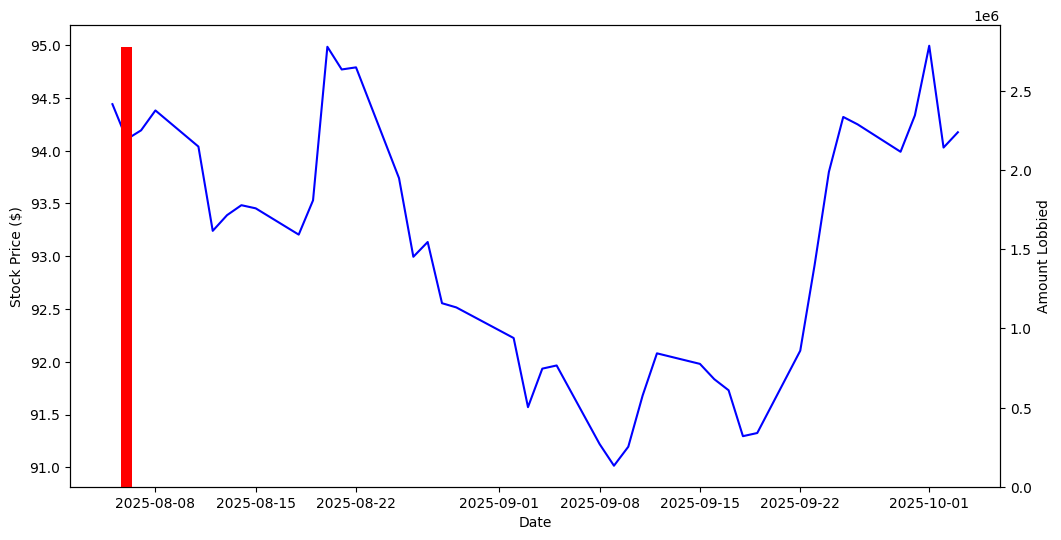

In [8]:
# grab the lobbied amount and group + sum by date
ticker_lobby_df = sum_amounts_by_date(df=df, ticker='SO')

# set start date to the beginning date of the dataframe
start_date = pd.to_datetime(df['Date'].iloc[-1])

#set end date to yesterday
end_date = dt.date.today() - dt.timedelta(days=1)

#pull ticker price data
df_ticker = yf.download(
    tickers='SO',
    start = start_date,
    end = end_date,
    interval = '1d',
    progress = False
)

df_ticker.reset_index(inplace = True)

df_ticker['avg_price'] = (df_ticker['High'] + df_ticker['Low']) / 2

fig, ax1 = plt.subplots(figsize=(12,6))
    
ax1.plot(df_ticker['Date'], df_ticker['avg_price'], color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price ($)')

ax2 = ax1.twinx()
ax2.bar(ticker_lobby_df['Date'], ticker_lobby_df['Amount'], color='red')
ax2.set_ylabel('Amount Lobbied')



In [65]:
ticker_lobby_df

,Date,Amount
0,2025-09-18,4850000


In [56]:
df_ticker

Price,Date,Close,High,Low,Open,Volume,avg_price
Ticker,,LMT,LMT,LMT,LMT,LMT,
0,2025-08-05,425.138367,426.955129,418.804570,420.263925,1643900,422.879850
1,2025-08-06,431.700500,433.457670,424.562573,424.671762,2032300,429.010122
2,2025-08-07,427.630188,431.700499,424.949731,427.312498,1490000,428.325115
3,2025-08-08,422.547272,430.449611,420.839728,428.067000,1477600,425.644669
4,2025-08-11,423.172729,424.721428,421.048214,422.914603,1462100,422.884821
5,2025-08-12,428.434326,428.464108,421.921841,422.835191,1492100,425.192974
6,2025-08-13,439.364594,440.238225,428.295356,429.387365,1890600,434.266790
7,2025-08-14,434.152618,440.684948,431.690569,432.881890,1733600,436.187759
8,2025-08-15,434.390869,438.232835,433.298830,434.668840,1501700,435.765833
